# Read In & Merge Tables

In [1]:
import pandas as pd

# Loaded datasets
disease = pd.read_csv("disease_incidence_service_data.csv")
pop = pd.read_csv("population_distribution.csv")
staff = pd.read_csv("health_worker_distribution.csv")
travel = pd.read_csv("travel_accessibility_data.csv")




In [2]:
# Merged on common keys
df = (disease
      .merge(pop[['month', 'facility_name', 'population_catchment']], on='month')
      .merge(staff[['month', 'total_staff']], on='month')
      .merge(travel[['month', 'travel_time_min']], on='month')
     )

df.rename(columns={'total_staff':'staff_count'}, inplace=True)

In [3]:
df.columns

Index(['month', 'facility_name_x', 'ward', 'lga', 'state', 'latitude',
       'longitude', 'facility_type', 'has_electricity', 'has_water_supply',
       'patient_visits_total', 'disease_cases', 'malaria_cases_total',
       'delivery_cases', 'facility_name_y', 'population_catchment',
       'staff_count', 'travel_time_min'],
      dtype='object')

In [13]:
df.head()

,month,facility_name_x,patient_visits_total,disease_cases,population_catchment,staff_count,travel_time_min,year,month_num,quarter,visits_per_staff,visits_per_1000_pop,disease_ratio,travel_per_staff,next_month_visits,overload_flag
0,2022-01-10,Taimakon Jamaa Health Clinic,1575,360,50142,15,75,2022,1,1,105.000000,31.410793,0.228571,5.000000,1575.0,0
1,2022-01-10,Taimakon Jamaa Health Clinic,1575,360,50142,15,54,2022,1,1,105.000000,31.410793,0.228571,3.600000,1575.0,0
2,2022-01-10,Taimakon Jamaa Health Clinic,1575,360,58859,15,75,2022,1,1,105.000000,26.758864,0.228571,5.000000,1575.0,0
3,2022-01-10,Taimakon Jamaa Health Clinic,1575,360,58859,15,54,2022,1,1,105.000000,26.758864,0.228571,3.600000,2813.0,0
4,2022-01-12,Fariya Idp Camp Clinic,2038,408,26372,27,66,2022,1,1,75.481481,77.278932,0.200196,2.444444,2038.0,0


# Feature Engineering

In [5]:
# Dropped unnecessary columns
df.drop([
    'facility_name_y',
    'ward',
    'lga',
    'state',
    'latitude',
    'longitude',
    'facility_type',
    'has_electricity',
    'has_water_supply',
    'malaria_cases_total',
    'delivery_cases'
], axis=1, inplace=True)


In [6]:
# Created Temporal Features
df['month'] = pd.to_datetime(df['month'])
df['year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month
df['quarter'] = df['month'].dt.quarter


In [7]:
# Created Utilization Features
df['visits_per_staff'] = df['patient_visits_total'] / df['staff_count']
df['visits_per_1000_pop'] = (df['patient_visits_total'] / df['population_catchment']) * 1000


In [8]:
# Created Disease Pressure Indicator
df['disease_ratio'] = df['disease_cases'] / df['patient_visits_total']

In [9]:
# Created Accessibility Burden
df['travel_per_staff'] = df['travel_time_min'] / df['staff_count']

In [10]:
# Created Lag Feature (for time-series forecasting)
df['next_month_visits'] = df.groupby('facility_name_x')['patient_visits_total'].shift(-1)

In [11]:
# Created Target variable for classification
df['overload_flag'] = (df['next_month_visits'] > df['staff_count'] * 200).astype(int)

In [12]:
# Dropped Rows with Missing Target
df = df.dropna(subset=['next_month_visits'])

# Model Training & Evaluation

In [16]:
# Prophet Model
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Example for one PHC
phc_data = df[df['facility_name_x'] == 'Taimakon Jamaa Health Clinic'][['month','patient_visits_total']]
phc_data.rename(columns={'month':'ds','patient_visits_total':'y'}, inplace=True)

model = Prophet()
model.fit(phc_data)
future = model.make_future_dataframe(periods=1, freq='M')
forecast = model.predict(future)

# Evaluate performance
df_cv = cross_validation(model, horizon='60 days')
metrics = performance_metrics(df_cv)
print(metrics[['rmse','mae','mape']])


13:52:58 - cmdstanpy - INFO - Chain [1] start processing
13:53:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

13:53:43 - cmdstanpy - INFO - Chain [1] start processing
13:53:46 - cmdstanpy - INFO - Chain [1] done processing
13:53:47 - cmdstanpy - INFO - Chain [1] start processing
13:53:50 - cmdstanpy - INFO - Chain [1] done processing
13:53:51 - cmdstanpy - INFO - Chain [1] start processing
13:54:10 - cmdstanpy - INFO - Chain [1] done processing
13:54:11 - cmdstanpy - INFO - Chain [1] start processing
13:54:11 - cmdstanpy - INFO - Chain [1] done processing
13:54:12 - cmdstanpy - INFO - Chain [1] start processing
13:54:12 - cmdstanpy - INFO - Chain [1] done processing
13:54:13 - cmdstanpy - INFO - Chain [1] start processing
13:54:20 - cmdstanpy - INFO - Chain [1] done processing


           rmse           mae      mape
0  24160.165587  24160.165587  9.193366
1  10905.446091   6154.465482  2.176459
2   1724.894346   1724.894346  0.691895
3  24160.165587  24160.165587  9.193366
4  10905.446091   6154.465482  2.176459
5   2973.724305   2973.724305  1.192830
6   6057.671135   5943.656313  3.029656


In [17]:
# Random Forest Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

features = ['patient_visits_total','population_catchment','staff_count','disease_cases','travel_time_min',
            'visits_per_staff','visits_per_1000_pop','disease_ratio']

X = df[features]
y = df['next_month_visits']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))


R²: 0.663064468860241
MAE: 529.027112841345


In [ ]:
# Installed xgboost library
!pip install xgboost

In [20]:
# XGBoost Regressor Model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(n_estimators=250, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", rmse)


RMSE: 844.7246447085383


In [21]:
# XGBoost Classifier Model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_class = df['overload_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, shuffle=False)

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))


Accuracy: 0.976303317535545
[[151   4]
 [  1  55]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       155
           1       0.93      0.98      0.96        56

    accuracy                           0.98       211
   macro avg       0.96      0.98      0.97       211
weighted avg       0.98      0.98      0.98       211



C:\Users\IPPIS\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [14:21:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Prediction

In [ ]:
# Kept only the engineered columns I need
month, facility_name, patient_visits_total, disease_cases,
population_catchment, staff_count, travel_time_min,
visits_per_staff, disease_ratio, visits_per_1000_pop,
next_month_visits, overload_flag


In [45]:
# Dropped missing rows if any
df = df.dropna(subset=['next_month_visits'])


In [46]:
# Split the Data
train = df[df['month'] < '2024-06-01']
test = df[df['month'] >= '2024-06-01']

X_train = train[features]
y_train_reg = train['next_month_visits']
y_train_clf = train['overload_flag']

X_test = test[features]
y_test_reg = test['next_month_visits']
y_test_clf = test['overload_flag']


In [47]:
# Trained Final Models (Regressor)
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_reg.fit(X_train, y_train_reg)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [48]:
# Trained Final Models (Classifier)
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train_clf)


C:\Users\IPPIS\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [15:10:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [49]:
# Evaluated and Validated (Regressor)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred_reg = xgb_reg.predict(X_test)
print("R²:", r2_score(y_test_reg, y_pred_reg))
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))


R²: 0.6046704881182063
MAE: 600.0027452666184
RMSE: 802.6281532257315


In [51]:
# Evaluated and Validated (Classifier)
from sklearn.metrics import classification_report, confusion_matrix

y_pred_clf = xgb_clf.predict(X_test)
print(confusion_matrix(y_test_clf, y_pred_clf))
print(classification_report(y_test_clf, y_pred_clf))


[[158   6]
 [  2  66]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       164
           1       0.92      0.97      0.94        68

    accuracy                           0.97       232
   macro avg       0.95      0.97      0.96       232
weighted avg       0.97      0.97      0.97       232



In [52]:
# Predicted next month’s patient visits
future_df = df[df['month'] == '2024-12-01'][features]
future_df['predicted_visits'] = xgb_reg.predict(future_df)


In [53]:
# Selected Features
features = [
    'patient_visits_total','population_catchment','staff_count','disease_cases',
    'travel_time_min','visits_per_staff','visits_per_1000_pop','disease_ratio'
]


In [54]:
# Deleted unwanted columns
future_X = future_df.drop(columns=['predicted_visits'], errors='ignore')[features]
future_X.columns

Index(['patient_visits_total', 'population_catchment', 'staff_count',
       'disease_cases', 'travel_time_min', 'visits_per_staff',
       'visits_per_1000_pop', 'disease_ratio'],
      dtype='object')

In [55]:
# Predicted overload risk
future_df['overload_flag_pred'] = xgb_clf.predict(future_X)

In [59]:
# Interpreted & Exported Results
import pandas as pd
from pandas.tseries.offsets import MonthBegin

# --- 0) Housekeeping: make sure we have the right column names and dtypes
if 'facility_name_x' in df.columns:
    df = df.rename(columns={'facility_name_x': 'facility_name'})
df['month'] = pd.to_datetime(df['month'])

# --- 1) Define the exact feature schema used for training
features = [
    'patient_visits_total','population_catchment','staff_count','disease_cases',
    'travel_time_min','visits_per_staff','visits_per_1000_pop','disease_ratio'
]

# --- 2) Choose the month you’re forecasting from (the latest month in your data)
asof_month = df['month'].max()

# Build a source frame that STILL has facility_name + month + features
future_source = df[df['month'] == asof_month].copy()

# Safety check for missing features
missing = [c for c in features if c not in future_source.columns]
if missing:
    raise ValueError(f"Missing required features in future_source: {missing}")

# --- 3) Predict using the trained models
future_source['predicted_visits']     = xgb_reg.predict(future_source[features])
future_source['overload_flag_pred']   = xgb_clf.predict(future_source[features])

# (Optional) Label the forecast month explicitly (next month)
future_source['forecast_month'] = (asof_month + MonthBegin(1))

# --- 4) Attach ward/LGA metadata (from df if present, else from registry_df)
meta_cols = ['facility_name','ward','lga']
if all(c in df.columns for c in meta_cols):
    meta = df[meta_cols].drop_duplicates('facility_name')
elif 'registry_df' in globals() and all(c in registry_df.columns for c in meta_cols):
    meta = registry_df[meta_cols].drop_duplicates('facility_name')
else:
    # as a last resort, fill blanks to avoid KeyError
    meta = future_source[['facility_name']].drop_duplicates().copy()
    meta['ward'] = None; meta['lga'] = None

out = future_source.merge(meta, on='facility_name', how='left')

# --- 5) Final columns and export
cols = ['facility_name','ward','lga','month','forecast_month','predicted_visits','overload_flag_pred']
out = out[[c for c in cols if c in out.columns]]

out.to_csv("phc_forecast_predictions.csv", index=False)
print("Saved phc_forecast_predictions.csv with", len(out), "rows")


Saved phc_forecast_predictions.csv with 10 rows


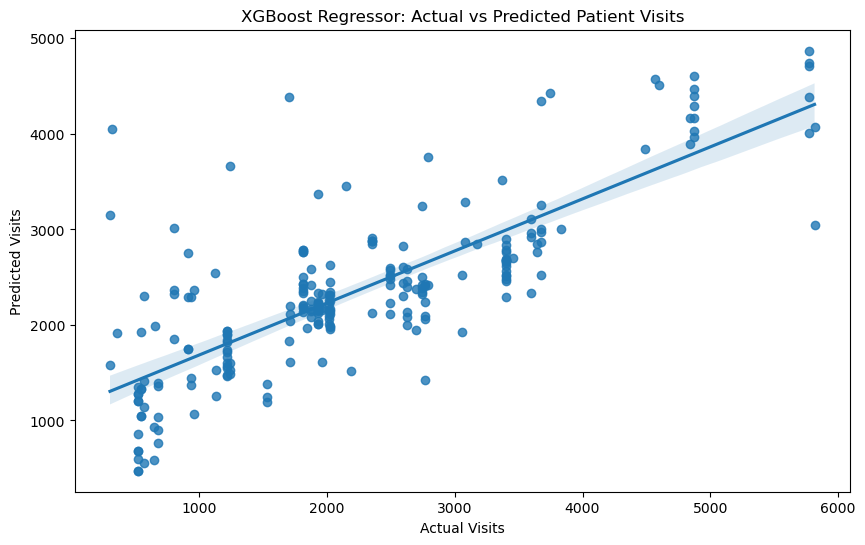

In [62]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.regplot(x=y_test_reg, y=y_pred_reg)
plt.xlabel("Actual Visits")
plt.ylabel("Predicted Visits")
plt.title("XGBoost Regressor: Actual vs Predicted Patient Visits")
plt.show()


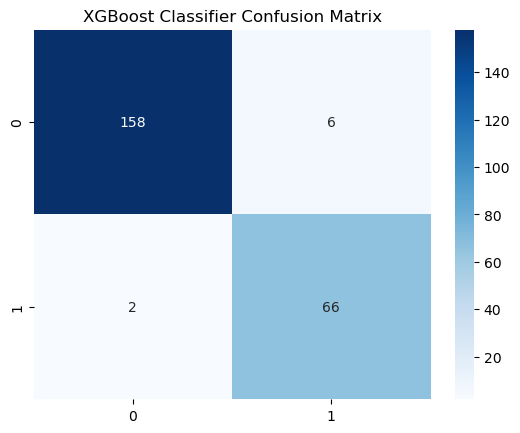

In [61]:
# Visualization
sns.heatmap(confusion_matrix(y_test_clf, y_pred_clf), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Classifier Confusion Matrix")
plt.show()


# Saving The Trained Models

In [63]:
# Saved the Models
import joblib

# Save the XGBoost Regressor
joblib.dump(xgb_reg, "xgb_regressor_model.pkl")

# Save the XGBoost Classifier
joblib.dump(xgb_clf, "xgb_classifier_model.pkl")

print("Models saved successfully as 'xgb_regressor_model.pkl' and 'xgb_classifier_model.pkl'")


Models saved successfully as 'xgb_regressor_model.pkl' and 'xgb_classifier_model.pkl'
